# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Imports

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Split the data into train val, and test set (starified)

In [3]:
img_dir = path
img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

breed_names = ['Akhal-Teke', 'Appaloosa', 'Orlov Trotter', 
               'Vladimir Heavy Draft', 'Percheron', 'Arabian', 'Friesian']

labels = [int(f[:2]) - 1 for f in img_files]
df = pd.DataFrame({'filename': img_files, 'label': labels})

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')
print(f'Train distribution:\n{train_df["label"].value_counts().sort_index()}')

Train: 536, Val: 67, Test: 67
Train distribution:
label
0    98
1    84
2    86
3    30
4    45
5    97
6    96
Name: count, dtype: int64


### Dataset Class

In [4]:
class HorseDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Transforms

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Create Dataloader objects

In [6]:
batch_size = 32

train_dataset = HorseDataset(train_df, img_dir, train_transform)
val_dataset = HorseDataset(val_df, img_dir, val_test_transform)
test_dataset = HorseDataset(test_df, img_dir, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}')

Train batches: 17, Val batches: 3, Test batches: 3


#### Display some images

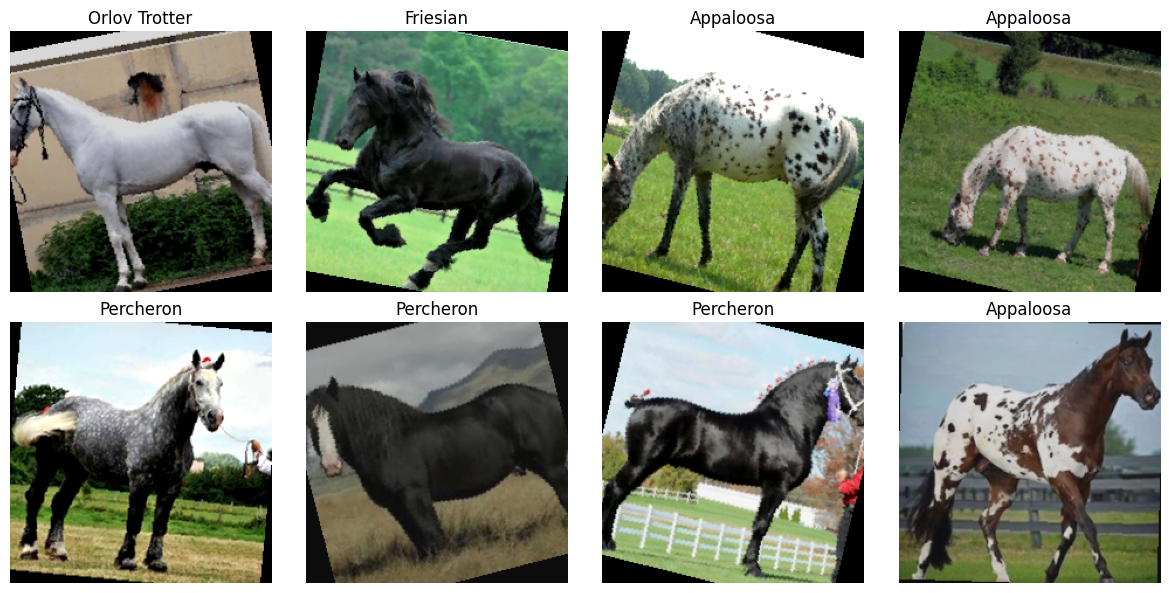

In [7]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(breed_names[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

### Define Model 

In [8]:
class HorseCNN(nn.Module):
    def __init__(self, num_classes):
        super(HorseCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

num_classes = 7
model = HorseCNN(num_classes)
model = model.to(device)

### define Loss and Optimizer

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

#### Build one_epoch_training function loop 

In [10]:
def one_epoch_training(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_accuracy = 100.0 * correct / total
    
    return epoch_train_loss, epoch_train_accuracy

#### Build one_epoch_validation function loop 

In [11]:
def one_epoch_validation(model, val_loader, loss_function, device):
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            val_loss = loss_function(outputs, labels)
            
            running_val_loss += val_loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100.0 * correct / total
    
    return epoch_val_loss, epoch_val_accuracy

### Combine all to train the model
it should Save the best model and track train and val loss and accuracy


In [12]:
def train_model(
    model,
    train_loader,
    val_loader,
    loss_function,
    optimizer,
    num_epochs,
    device,
    save_path="best_model_checkpoint.pth"
):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0

    print("=== Training Started ===")

    for epoch in range(num_epochs):
        train_loss, train_acc = one_epoch_training(
            model, train_loader, loss_function, optimizer, device
        )

        val_loss, val_acc = one_epoch_validation(
            model, val_loader, loss_function, device
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
        )

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc

            checkpoint = {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_accuracy": best_val_accuracy
            }

            torch.save(checkpoint, save_path)

            print(f"✔ Best model saved (Val Acc = {best_val_accuracy:.2f}%)")

    print("=== Training Finished ===")

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies
    }

In [13]:
num_epochs = 25

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

=== Training Started ===
Epoch [1/25] | Train Loss: 20.2121, Train Acc: 22.95% | Val Loss: 3.9816, Val Acc: 34.33%
✔ Best model saved (Val Acc = 34.33%)
Epoch [2/25] | Train Loss: 3.7967, Train Acc: 33.58% | Val Loss: 1.6060, Val Acc: 46.27%
✔ Best model saved (Val Acc = 46.27%)
Epoch [3/25] | Train Loss: 1.6217, Train Acc: 38.62% | Val Loss: 1.4245, Val Acc: 53.73%
✔ Best model saved (Val Acc = 53.73%)
Epoch [4/25] | Train Loss: 1.4889, Train Acc: 46.64% | Val Loss: 1.2805, Val Acc: 56.72%
✔ Best model saved (Val Acc = 56.72%)
Epoch [5/25] | Train Loss: 1.4526, Train Acc: 46.27% | Val Loss: 1.3158, Val Acc: 49.25%
Epoch [6/25] | Train Loss: 1.3946, Train Acc: 47.76% | Val Loss: 1.2401, Val Acc: 49.25%
Epoch [7/25] | Train Loss: 1.3549, Train Acc: 49.44% | Val Loss: 1.2876, Val Acc: 56.72%
Epoch [8/25] | Train Loss: 1.3231, Train Acc: 51.49% | Val Loss: 1.2573, Val Acc: 58.21%
✔ Best model saved (Val Acc = 58.21%)
Epoch [9/25] | Train Loss: 1.3187, Train Acc: 53.17% | Val Loss: 1.1977,

### test the model on test set

### show some predictions with the images

### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

### Load the model